# **Topic Mining for Research Articles using LSA/SVD**
##Problem Statement
In this era of research, we have access to huge archives of freely avaiable research papers. Therefore, finding relevent papers is time consuming. Topic minning or Topic modelling could facilitate this search by some means.
##Dataset
Dataset is very recent and is publically available. It contains two features/attributes:
1. Title 
2. Abstract

According to dataset each research article could relate to more then one topic. The possible topics could be:
1. Computer Science
2. Physics
3. Mathematics
4. Statistics
5. Quantitative Biology
6. Quantitative Finance

##Goal
Our goal is to find 3 major topics among all and the frequent vocabulary they contain. We will use Abstract for our task and will apply data mining techniques i.e LSA in this case to extract topics. 



**Link to dataset:** https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles/download

##Imports and Dataset Loading

In [1]:
!wget https://www.dropbox.com/s/kqd3ihgjvcvzkbi/research_abstrcat.zip?dl=0

--2022-02-10 17:44:22--  https://www.dropbox.com/s/kqd3ihgjvcvzkbi/research_abstrcat.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/kqd3ihgjvcvzkbi/research_abstrcat.zip [following]
--2022-02-10 17:44:22--  https://www.dropbox.com/s/raw/kqd3ihgjvcvzkbi/research_abstrcat.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc17a9883767cb159c3f8d169755.dl.dropboxusercontent.com/cd/0/inline/Bffnhn8rvCWHD4L_PgGKQDeGRbnHKErHoV2iZt1Uv4vpOBSsKudNUB00Id0GzamUabTL4tuUZCpnxPUiSNohMlehY4se-pnO61nPySjktOBYOxmjam1ROOv6HJKcVi3dzktwWe5EWHBgepl0Czr8acMd/file# [following]
--2022-02-10 17:44:22--  https://uc17a9883767cb159c3f8d169755.dl.dropboxusercontent.com/cd/0/inline/Bffnhn8rvCWHD4L_PgGKQDeGRbnHKErHoV2iZt1Uv4vpOBSsKudNUB00Id

In [2]:
!unzip /content/research_abstrcat.zip?dl=0

Archive:  /content/research_abstrcat.zip?dl=0
  inflating: train.csv               


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import re
from functools import reduce
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [4]:
data = pd.read_csv('train.csv')

##Data Analysis

In [5]:
data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [6]:
#checking if there exist any null/empty abstract 
data['ABSTRACT'].isnull().any()

False

Our dataset contains **20972 articles** and **26267 labels**. There exist no article without label. And the reason why number of labels is greater is becuase each article may belong to one or more category/topic. 

In [9]:
x = data.iloc[:,3:].sum() #caluclating how many research articles are there for each category
rowsum = data.iloc[:,2:].sum(axis = 1) #calculating how much categroies each paper belong to
no_of_label_count = 0

for sum in rowsum.items():
  if sum == 0:
    no_of_label_count += 1

print("Total number of articles = ",len(data))
print("Total number of articles without label = ",no_of_label_count)
print("total labels = ",x.sum())

Total number of articles =  20972
Total number of articles without label =  0
total labels =  26267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


##Visualization

Frequency of categories by which an article may belong. 

In [10]:
topic_frequency = list(x)
top = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

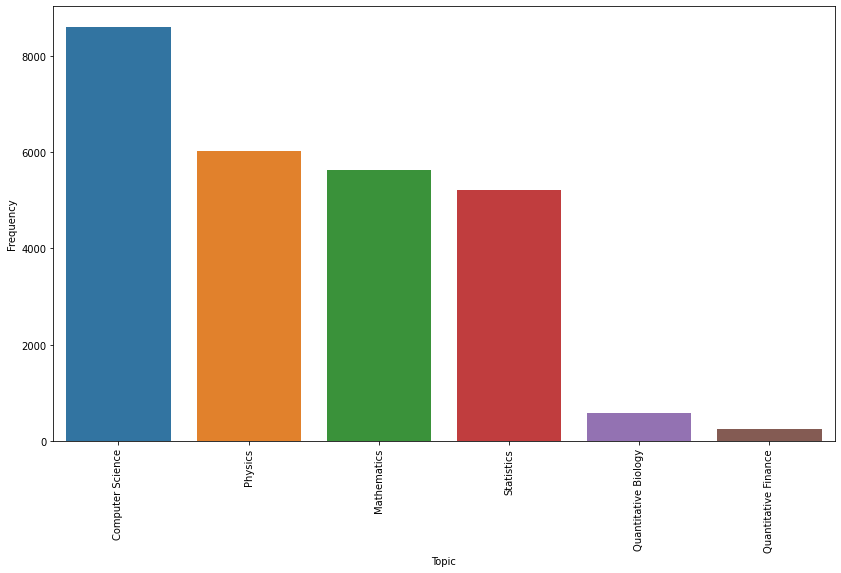

In [11]:
plt.figure(figsize=(14,8))
sns.barplot(x=top, y=topic_frequency)
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.xticks(rotation=90);

##Pre-Processing

Since we have to deal with unstructred data (Natural Language). It is very important to clean it for further reuse therefore we pre process our data.

In [12]:
data['ABSTRACT'][0]

"  Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used with different binary classifiers in a diagn

In [13]:
data['ABSTRACT'] = data['ABSTRACT'].str.lower()

In [14]:
#Removing newlines
def remove_newline(text):
    return re.sub('\n',' ', text)
data['ABSTRACT'] = data['ABSTRACT'].apply(lambda x: remove_newline(x))

In [15]:
#Removing anything that comes between brackets as it is redundent and brings no useful information
def rem_inbtw(text):
  return re.sub('\((.*?)\)', '', text)
data['ABSTRACT'] = data['ABSTRACT'].apply(lambda x: rem_inbtw(x))

In [16]:
GOOD_SYMBOLS_RE = re.compile('[^a-z]')
#Removing any character other than those of described above
def filter_out_uncommon_symbols(text):
    return GOOD_SYMBOLS_RE.sub(' ', text)
data['ABSTRACT'] = data['ABSTRACT'].apply(lambda x: filter_out_uncommon_symbols(x))

In [17]:
def strip_text(text):
    return re.sub('  +',' ',text)
data['ABSTRACT'] = data['ABSTRACT'].apply(lambda x: strip_text(x))

In [18]:
#Removing unnecessary spaces
def strip_text(text):
    return text.strip()
data['ABSTRACT'] = data['ABSTRACT'].apply(lambda x: strip_text(x))

In [19]:
data['ABSTRACT'][0]

'predictive models allow subject specific inference when analyzing disease related alterations in neuroimaging data given a subject s data inference can be made at two levels global i e identifiying condition presence for the subject and local i e detecting condition effect on each individual measurement extracted from the subject s data while global inference is widely used local inference which can be used to form subject specific effect maps is rarely used because existing models often yield noisy detections composed of dispersed isolated islands in this article we propose a reconstruction method named rsm to improve subject specific detections of predictive modeling approaches and in particular binary classifiers rsm specifically aims to reduce noise due to sampling error associated with using a finite sample of examples to train classifiers the proposed method is a wrapper type algorithm that can be used with different binary classifiers in a diagnostic manner i e without informat

In [20]:
data

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,predictive models allow subject specific infer...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,rotation invariance and translation invariance...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,we introduce and develop the notion of spheric...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,the stochastic landau lifshitz gilbert equatio...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,fourier transform infra red spectra of samples...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,machine learning is finding increasingly broad...,1,1,0,0,0,0
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,polycrystalline diamond coatings have been gro...,0,1,0,0,0,0
20969,20970,Analysing Soccer Games with Clustering and Con...,we present a new approach for identifying situ...,1,0,0,0,0,0
20970,20971,On the Efficient Simulation of the Left-Tail o...,the sum of log normal variates is encountered ...,0,0,1,1,0,0


In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
STOPWORDS=stopwords.words('english')

We concatinate predefined stopwords with the most common words used in all the articles to have a better representation of topics in the end (Main goal is to get rid of redundent words in all topics).

In [23]:
STOPWORDS = STOPWORDS + ['i e', 'learning', 'data', 'we', 'in', 'art', 'state', 'of', 'the', 'paper'
, 'model', 'models', 'algorithm', 'network', 'methods', 'approach', 'proposed', 'showed', 'problem'
, 'using', 'response', 'two', 'new', 'one', 'based', 'used', 'study', 'method', 'show', 'well', 
'non', 'use', 'propose', 'system', 'also', 'systems', 'large', 'high']

##Encoding

Here we get some semantic information about the sentence. Importance is given to the words less common in all sentences. This converts the data into numerical format represented by matrix.

In [24]:
vectorizer = TfidfVectorizer(stop_words=STOPWORDS,
                             max_features= 1000,  
                             ngram_range = (1,4), 
                             smooth_idf=True) #to avoid zero division we set smooth_idf to TRUE

X = vectorizer.fit_transform(data['ABSTRACT'])

X.shape

(20972, 1000)

Here we get the names of the features (words in abstracts), this is our vocabulary. 

In [25]:
dictionary = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##Model Definition- (LSA/SVD)

Here we pass as parameter top topics that we want to extract as **n_components**. Itried it with 4,5,6 but the results were very disappointing therefore I extracted top 3 topics and achived best results among all. 

In [26]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=3, algorithm='randomized')
lsa = svd_model.fit_transform(X)

In [27]:
pd.options.display.float_format = '{:,.16f}'.format
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_1", "topic_2", "topic_3"])
topic_encoded_df["ABSTRACT"] = data['ABSTRACT']
display(topic_encoded_df[["ABSTRACT", "topic_1", "topic_2", "topic_3"]])

,ABSTRACT,topic_1,topic_2,topic_3
0,predictive models allow subject specific infer...,0.2071891806195836,0.0567651933794098,0.0202123198643426
1,rotation invariance and translation invariance...,0.1173418837819297,0.1743991297985862,0.0574343763531573
2,we introduce and develop the notion of spheric...,0.1421031212838040,-0.0521692706641622,-0.1372000962235182
3,the stochastic landau lifshitz gilbert equatio...,0.1931405942040868,-0.1198886957486045,-0.1775586816547085
4,fourier transform infra red spectra of samples...,0.2022073234877554,0.1239405920651345,0.0474769109614565
...,...,...,...,...
20967,machine learning is finding increasingly broad...,0.2658088571489268,0.1967297726035948,0.0337455811015355
20968,polycrystalline diamond coatings have been gro...,0.1758350580046567,-0.0799876626928605,0.0796650017289814
20969,we present a new approach for identifying situ...,0.2320740862271884,0.1014434278278053,0.0443675602168403
20970,the sum of log normal variates is encountered ...,0.2244416947775282,0.0197981638868442,-0.0795361180570024


In [28]:
encoding_matrix = pd.DataFrame(svd_model.components_, index = ["topic_1", "topic_2", "topic_3"], columns = (dictionary)).T
encoding_matrix

,topic_1,topic_2,topic_3
ability,0.0192322977135366,0.0205213105140465,0.0107959378287315
able,0.0301679542010698,0.0246825538368258,0.0133626132064894
access,0.0166161994003327,0.0116117103402418,0.0083041882864598
according,0.0142663860767034,0.0002691812734513,0.0012427851693836
account,0.0221807034571438,-0.0053490235322705,0.0147981894086972
...,...,...,...
would,0.0188156788366702,-0.0022971033592190,0.0151891889633883
years,0.0218188190864216,0.0130146439764505,0.0147572711700058
yet,0.0197081545267099,0.0115633579403511,0.0083904235971185
yields,0.0155540562530934,-0.0036199911588397,-0.0074904228518626


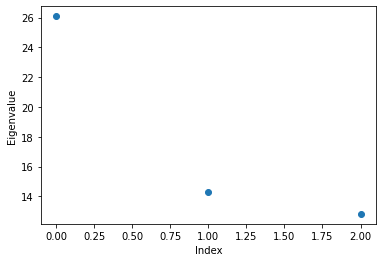

In [41]:
plt.plot((svd_model.singular_values_), 'o')
plt.ylabel("Eigenvalue")
plt.xlabel("Index")
plt.show()

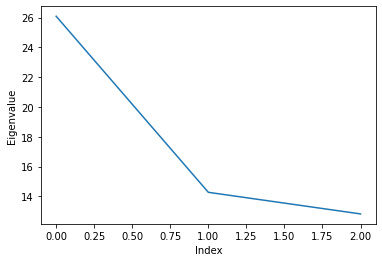

In [40]:
plt.plot(svd_model.singular_values_)
plt.ylabel("Eigenvalue")
plt.xlabel("Index")
plt.show()

Here we extract top 20 words inside each topic. This helps us to label the topic for further analysis at the end. 

In [32]:
for i, latent_component in enumerate(svd_model.components_):
    terms_comp = zip(dictionary, latent_component) #for each topic score is assigned to 1000 terms obtained from tf-idf so we are zipping term and its score 
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:20] #sorting is descending order DEFAULT is ascending 
    terms_str = ",".join([term[0] for term in sorted_terms])
    print(f"Topic {i + 1}: {terms_str}")

Topic 1: time,results,networks,different,performance,number,analysis,order,present,function,information,neural,space,algorithms,first,work,field,set,deep,framework
Topic 2: neural,networks,deep,training,neural networks,performance,task,tasks,classification,image,machine,information,dataset,datasets,images,convolutional,trained,algorithms,accuracy,features
Topic 3: magnetic,spin,phase,temperature,energy,field,quantum,electron,transition,low,optical,states,magnetic field,effect,observed,mass,range,measurements,electronic,coupling


In [33]:
#Values assoiated to each word corresponding to respected topic 
for i, comp in enumerate(svd_model.components_): 
    terms_comp = zip(dictionary, comp) 
    sorted_terms = sorted(terms_comp, key= lambda x:x[1],        
    reverse=True)[:20]
    for t in sorted_terms: 
        print(f"Topic {i + 1}: {t}")

Topic 1: ('time', 0.14228619568383483)
Topic 1: ('results', 0.1286219768405486)
Topic 1: ('networks', 0.10681276514190707)
Topic 1: ('different', 0.09448816992015793)
Topic 1: ('performance', 0.09338223186373487)
Topic 1: ('number', 0.09271619427527025)
Topic 1: ('analysis', 0.09243538280705854)
Topic 1: ('order', 0.08621353511615011)
Topic 1: ('present', 0.08532807950986228)
Topic 1: ('function', 0.08429400118121413)
Topic 1: ('information', 0.08419003415674392)
Topic 1: ('neural', 0.08298144338283596)
Topic 1: ('space', 0.08103029329827226)
Topic 1: ('algorithms', 0.08054398573667536)
Topic 1: ('first', 0.08009370207683571)
Topic 1: ('work', 0.07946661687319036)
Topic 1: ('field', 0.07917739966637724)
Topic 1: ('set', 0.07603850089863189)
Topic 1: ('deep', 0.07580909244295571)
Topic 1: ('framework', 0.07446214614383956)
Topic 2: ('neural', 0.22625788040966377)
Topic 2: ('networks', 0.2177334925953676)
Topic 2: ('deep', 0.19213044565955115)
Topic 2: ('training', 0.17124670161279532)
T

##Final Evaluation

In [34]:
def get_model_topics(model, topics):
    word_dict = {}
    for i, latent_component in enumerate(svd_model.components_):
      terms_comp = zip(dictionary, latent_component)  
      sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10] 
      terms_str = [a_tuple[0] for a_tuple in sorted_terms]
      word_dict[topics[i]] = terms_str

    return pd.DataFrame(word_dict)

In [49]:
def get_inference(model, vectorizer, topics, text, threshold):
    v_text = vectorizer.transform([text])
    score = svd_model.transform(v_text)

    labels = set()
    for i in range(len(score[0])):
        if score[0][i] > threshold:
            labels.add(topics[i])  #we only those topic to label set for which score is greater then 0

    if not labels:
        return 'None', -1, set()

    return topics[np.argmax(score)], score, labels

Random inputs to test our model

In [36]:
text = 'Artificial intelligence (AI) is the ability of a computer or a robot controlled by a computer to do tasks that are usually done by humans because they require human intelligence and discernment.'

In [ ]:
text = 'induction is the production of an electromotive force across an electrical conductor in a changing magnetic field. Michael Faraday is generally credited with the discovery of induction in 1831, and James Clerk Maxwell mathematically described it as Faraday law of induction.'

In [ ]:
text = 'Many concepts of deep learning concepts have been derived by assimilating the concepts of statistics. '

In [ ]:
text = 'Fitness and sport have drawn significant attention in wearable and persuasive computing. Physical activities are worthwhile for health, well-being, improved fitness levels, lower mental pressure and tension levels. Nonetheless, during high-power and commanding workouts, there is a high likelihood that physical fitness is seriously influenced. Jarring motions and improper posture during workouts can lead to temporary or permanent disability. With the advent of technological advances, activity acknowledgment dependent on wearable sensors has pulled in countless studies. Still, a fully portable smart fitness suite is not industrialized, which is the central need of today’s time, especially in the Covid-19 pandemic. Considering the effectiveness of this issue, we proposed a fully portable smart fitness suite for the household to carry on their routine exercises without any physical gym trainer and gym environment. The proposed system considers two exercises, i.e., T-bar and bicep curl with the assistance of the virtual real-time android application, acting as a gym trainer overall. The proposed fitness suite is embedded with a gyroscope and EMG sensory modules for performing the above two exercises. It provided alerts on unhealthy, wrong posture movements over an android app and is guided to the best possible posture based on sensor values. The KNN classification model is used for prediction and guidance for the user while performing a particular exercise with the help of an android application-based virtual gym trainer through a text-to-speech module. The proposed system attained 89% accuracy, which is quite effective with portability and a virtually assisted gym trainer feature. '

In [51]:
text = 'Graph convolution neural networks are really good for detcting anti money laundering'

In [ ]:
text = 'the branch of science concerned with the nature and properties of matter and energy. The subject matter of physics includes mechanics, heat, light and other radiation, sound, electricity, magnetism, and the structure of atoms.'

In [42]:
text = 'the theory and development of computer systems able to perform tasks normally requiring human intelligence, such as visual perception, speech recognition, decision-making, and translation between languages.'

In [ ]:
text = 'the abstract science of number, quantity, and space, either as abstract concepts ( pure mathematics ), or as applied to other disciplines such as physics and engineering ( applied mathematics ).'

In [ ]:
text = 'Computer science is the study of computation, automation, and information. Computer science spans theoretical disciplines, such as algorithms, theory of computation, and information theory, to practical disciplines including the design and implementation of hardware and software.'

In [44]:
text = 'Algebra is one of the broad areas of mathematics. Roughly speaking, algebra is the study of mathematical symbols and the rules for manipulating these symbols; it is a unifying thread of almost all of mathematics'

In [ ]:
text = 'Deep learning is a machine learning technique that teaches computers to do what comes naturally to humans: learn by example. ... In deep learning, a computer model learns to perform classification tasks directly from images, text, or sound.'

In [ ]:
text = 'Static electricity is an imbalance of electric charges within or on the surface of a material or between materials. The charge remains until it is able to move away by means of an electric current or electrical discharge.'

From the analysis of top words from each topic. I infer that these topic belong to following categories:
1. Computer Science/ Statistics / Mathematics
2. AI 
3. Physics

Since most of the reseasrch articles were AI based therefore there is an overlap between statistics, mathematics and computer science topic. And it is evident from our dataset as well that one research article may belong to one or more categories. 

**Note:** AI was not mentioned as a topic inside our dataset but with the help of LSA/SVD we have extracted this specific topic out of corpora. 

In [37]:
lsa_topics = ['Computer Science/ Statistics / Mathematics', 'AI', 'Physics']


Testing how our SVD/LSA model performs when we pass random text as input. 

In [52]:
print(get_model_topics(lsa, lsa_topics))
topic, score, _ = get_inference(lsa, vectorizer, lsa_topics, text, 0) # '_' represents the labels but I do not display it since its is already evident from output
print()
print(text)
print(topic, score)
print()

  Computer Science/ Statistics / Mathematics               AI      Physics
0                                       time           neural     magnetic
1                                    results         networks         spin
2                                   networks             deep        phase
3                                  different         training  temperature
4                                performance  neural networks       energy
5                                     number      performance        field
6                                   analysis             task      quantum
7                                      order            tasks     electron
8                                    present   classification   transition
9                                   function            image          low

Graph convolution neural networks are really good for detcting anti money laundering
AI [[ 0.13687763  0.25320411 -0.00126037]]

